In [3]:
# !pip install scann
# !pip install --upgrade google-cloud-aiplatform

### Inicialización

In [4]:
# Embedding Models: "textembedding-gecko@latest", "textembedding-gecko@001", "textembedding-gecko-multilingual@latest"
# Tablas - Production: 'e-commerce-llm-chatbot.ecommerce_db', Test: 'e-commerce-llm-chatbot.ecommerce_db_test'

import yaml
with open("config.yaml", "r") as config_file:
    config_data = yaml.safe_load(config_file)

# Configuraciones para la conexión del proyecto
PROJECT_ID = config_data["project_id"]
REGION = config_data["region"]
BUCKET = config_data["bucket"]
MODEL_NAME = config_data["model_name"]
DATASET_ID = config_data["dataset_id"]
VERBOSE = config_data["verbose"] # Puede evitar cargos adicionales de quota

### Funcionamiento Esperado del Embedding

In [ ]:
# Importar e inicializar Vertex AI para Python
import vertexai
from vertexai.language_models import TextEmbeddingInput, TextEmbeddingModel
vertexai.init(project = PROJECT_ID, location = REGION)
embedding_model = TextEmbeddingModel.from_pretrained(MODEL_NAME)

# Función para empaquetar la lógica del embedding
def get_embedding(text: str) -> list:
    """Generate text embedding with a Large Language Model."""
    try: return embedding_model.get_embeddings([text])[0].values
    except: return [] # En caso de gasto de quota esto es posible

# Función para indexar en base métrica
def compare(embeddings,idx1,idx2):
    return cosine_similarity([embeddings[idx1]],[embeddings[idx2]])[0]

if VERBOSE:
    # Ejemplo del uso de un embedding (Vector de embedding es de largo cte)
    vec = [get_embedding("Love is the meaning of life.")]
    print(f"Length = {len(vec[0])}, \nVector (5 elems):", vec[0][:5])

    # Ejemplo del uso de similitud para busqueda
    from sklearn.metrics.pairwise import cosine_similarity
    vec_1 = [get_embedding("What is the meaning of life?")]
    vec_2 = [get_embedding("How does one spend their time well on Earth?")]
    vec_3 = [get_embedding("Would you like a salad?")]
    print(cosine_similarity(vec,vec_1), cosine_similarity(vec,vec_2), cosine_similarity(vec,vec_3))

### Conexión con la base de datos

In [6]:
from google.cloud import storage, bigquery
import pandas as pd

# Conexión a clientes de GoogleCloudStorage (Buckets) y para conectarse a BigQuery (Database)
gcs_client = storage.Client(project = PROJECT_ID) # GCS contiene "buckets"
bq_client = bigquery.Client(project = PROJECT_ID) # BQ contiene "databases"

# Creación de bucket en GCS si no existe
if not gcs_client.lookup_bucket(BUCKET):
    bucketDef = gcs_client.bucket(BUCKET)
    bucket = gcs_client.create_bucket(bucketDef, project=PROJECT_ID, location=REGION)
    print(f'Created Bucket: {gcs.lookup_bucket(BUCKET).name}')
else:
    bucketDef = gcs_client.bucket(BUCKET)
    print(f'Bucket already exist: {bucketDef.name}')
    
elements = bucketDef.list_blobs()
for a in elements: print(a.name) 

Bucket already exist: e-commerce-llm-bucket
production/
test/
test/embedding-test.csv
test/finetune-test.json
test/products-test.csv


In [7]:
# Cargar datos de BigQuery
query = f"""
SELECT * FROM `{DATASET_ID}.products`
"""
df = bq_client.query(query).to_dataframe()
# df = pd.read_csv('products.csv') # Cargar datos desde CSV

In [ ]:
# df.to_csv('products.csv', index=False)

In [8]:
df.tail(3) # Empieza de 0

,uuid,Enlace,Marca,Nombre,Badge_Promocional,Descripci__n_del_Producto,Precio_Anterior,Precio_Actual,Categoria_1,Categoria_2,Categoria_3
84,81808144-fac9-40c6-9175-442aceaacfe2,https://www.elpalaciodehierro.com/professional...,Professional Gourmet,Escurridor de Platos de 2 Niveles en Aluminio,Meses Sin Intereses,Escurridor de platos Professional Gourmet elab...,2950.0,2212.5,hogar,organizacion-limpieza,cocina
85,90a22b62-6275-413d-abe3-fb67905966bc,https://www.elpalaciodehierro.com/zense-organi...,Zense,Organizador con Repisas Mykonos en bambú,Meses Sin Intereses,Organizador con Repisas Zense Mykonos elaborad...,1699.0,1359.2,hogar,organizacion-limpieza,organizadores
86,9bb84f4a-1066-426f-9f86-b722598bdfa2,https://www.elpalaciodehierro.com/rolser-tabur...,Rolser,Taburete en aluminio,Meses Sin Intereses,Taburete Rolser elaborado en aluminio color ne...,1150.0,805.0,hogar,organizacion-limpieza,escaleras


In [9]:
# Cargar datos de BigQuery
query = f"""
SELECT * FROM `{DATASET_ID}.embeddings`
"""
df_embeddings = bq_client.query(query).to_dataframe()
# df_embeddings = pd.read_csv('df_embeddings.csv') # Cargar datos desde CSV

In [10]:
df_embeddings.tail(3)

,uuid,text_content
84,f961d9be-e5d3-4473-abb4-f1144754bbcd,Marca: Hamilton Beach\nNombre: Purificador de ...
85,fa21955f-931c-4026-8dca-76adc8aa4500,Marca: Lacrosse\nNombre: Difusor Pure Oxygen\n...
86,fc94b897-6752-4b30-9e11-1b0c820d60d5,Marca: Samsung\nNombre: Horno de Microondas 1....


In [12]:
import time
import tqdm

# Verificar si la columna "embedding" ya existe o algun valor es nulo
if "embedding" not in df_embeddings.columns or df_embeddings["embedding"].isnull().any():
    df_embeddings["embedding"] = None
    for index, row in tqdm.tqdm(df_embeddings.iterrows()):
        time.sleep(1) # Evita sobrepasar la quota
        text_content = row["text_content"]
        embedding = get_embedding(text_content)
        df_embeddings.at[index, "embedding"] = embedding


87it [01:33,  1.07s/it]


In [ ]:
# df_embeddings.to_csv('df_embeddings.csv', encoding='utf-8', index=False)

In [13]:
# Agregar una columna 'Categoria' al DataFrame df para usar en PCA
df['Categoria'] = df['Categoria_3'].fillna(df['Categoria_2'].fillna(df['Categoria_1']))
df.head(5)

,uuid,Enlace,Marca,Nombre,Badge_Promocional,Descripci__n_del_Producto,Precio_Anterior,Precio_Actual,Categoria_1,Categoria_2,Categoria_3,Categoria
0,23b38da3-2f76-45ac-9994-975ed92f097a,https://www.elpalaciodehierro.com/royal-canin-...,Royal Canin,Alimento Seco para Perro Cachorro Razas Pequeñ...,None,Alimento Seco para Perro Cachorro Razas Pequeñ...,405.0,364.5,mascotas,None,None,mascotas
1,6dab3747-e092-4001-bedd-86e2c32c4df3,https://www.elpalaciodehierro.com/assouline-pa...,Assouline,Paris Chic,None,"Oliver Pilcher, ""Paris Chic""; París es la ciud...",2950.0,2507.5,libros,None,None,libros
2,14a730b0-daa3-4458-81c0-555f9f570a71,https://www.elpalaciodehierro.com/nautica-toal...,Nautica,Toalla de Medio Baño Mainsheet Rojo,None,Toalla Nautica de medio baño confeccionada en ...,785.0,471.0,hogar,bano,toallas-de-bano,toallas-de-bano
3,15a61b42-d5bb-40e7-8378-a84b04607d69,https://www.elpalaciodehierro.com/nautica-set-...,Nautica,Set 6 Toallas Belle Heaven Gris,None,Set de toallas Nautica Belle Heaven confeccion...,2599.0,1559.4,hogar,bano,accesorios-de-bano,accesorios-de-bano
4,e96555ff-6f0b-4d45-a92d-e6a899e0e5ce,https://www.elpalaciodehierro.com/bovi-funda-p...,Bovi,Funda para Duvet King Size Gris,None,Funda para Duvet King Size Bovi confeccionado ...,5999.0,1799.7,hogar,blancos,accesorios-de-cama,accesorios-de-cama


In [14]:
df_embeddings.tail(3)

,uuid,text_content,embedding
84,f961d9be-e5d3-4473-abb4-f1144754bbcd,Marca: Hamilton Beach\nNombre: Purificador de ...,"[0.031020723283290863, -0.06237144395709038, -..."
85,fa21955f-931c-4026-8dca-76adc8aa4500,Marca: Lacrosse\nNombre: Difusor Pure Oxygen\n...,"[-0.02130400761961937, -0.03456888720393181, -..."
86,fc94b897-6752-4b30-9e11-1b0c820d60d5,Marca: Samsung\nNombre: Horno de Microondas 1....,"[0.021157704293727875, -0.031924739480018616, ..."


In [15]:
import numpy as np
# Generar arreglo de embedding
embeddings = []
for emb in df_embeddings["embedding"]:
    arr = np.array(emb)
    embeddings.append(arr)
embeddings_array = np.array(embeddings)
print("Shape: " + str(embeddings_array.shape))


Shape: (87, 768)


In [16]:
from sklearn.decomposition import PCA
# Aplicar PCA
PCA_model = PCA(n_components = 2)
PCA_model.fit(embeddings_array)
new_values = PCA_model.transform(embeddings_array)

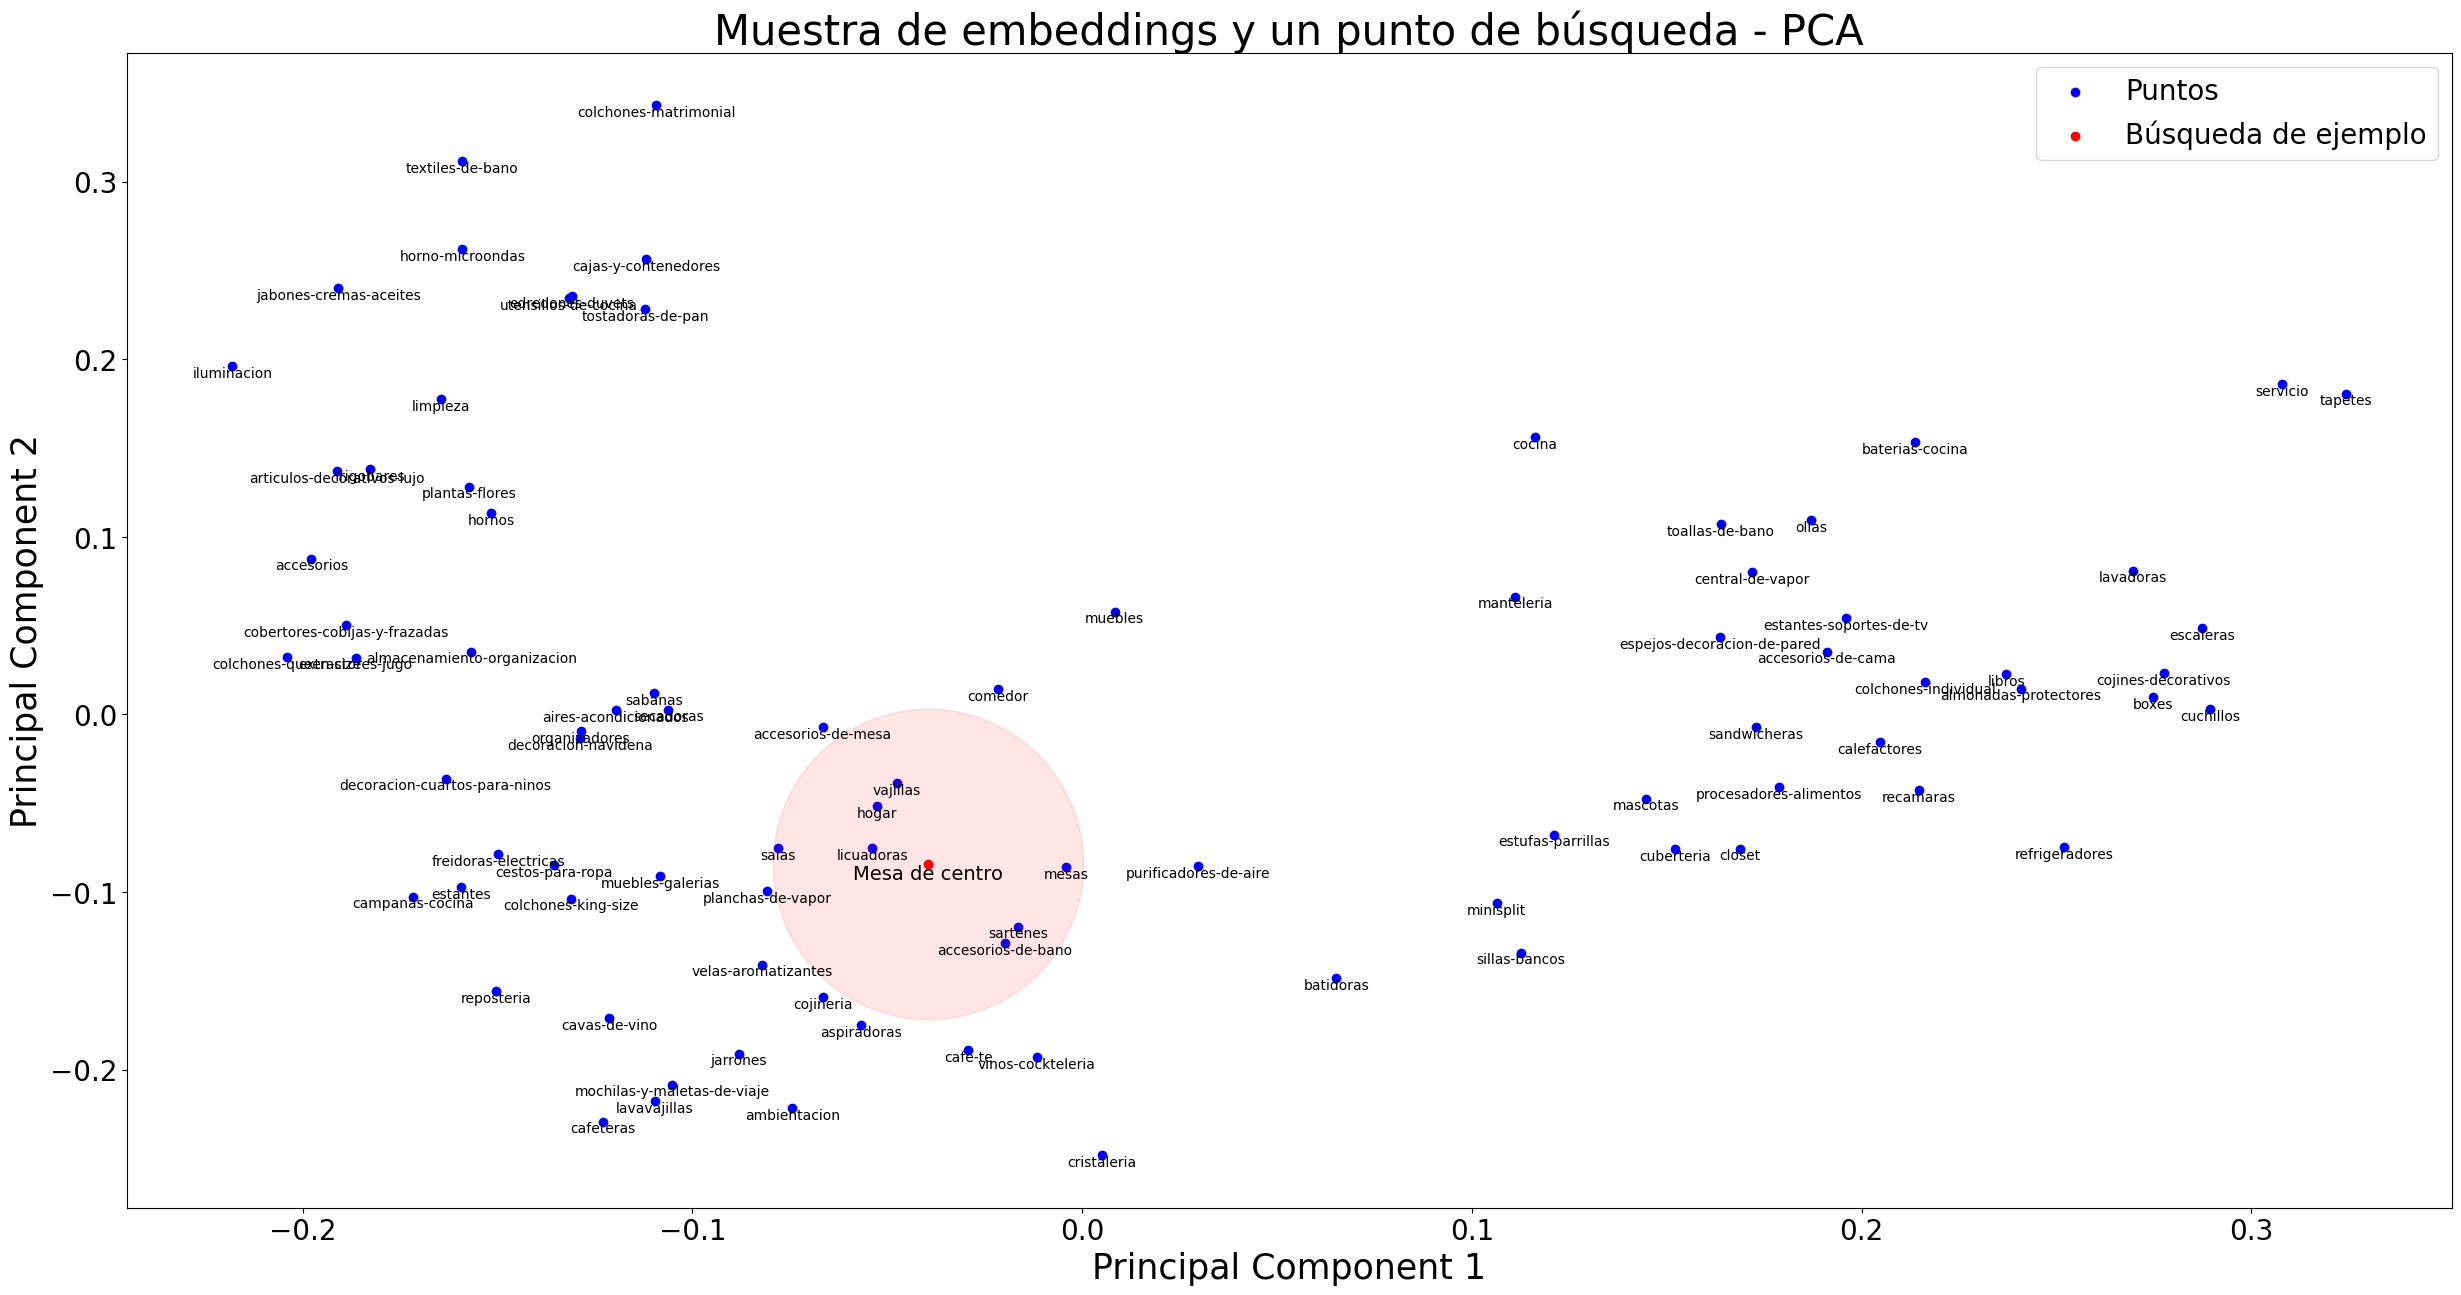

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

query = "Mesa de centro"
embed_q = np.array(embedding_model.get_embeddings([query])[0].values)
pca_q = PCA_model.transform(embed_q.reshape(1, -1))[0]

# Suponiendo que 'new_values' contiene los resultados del PCA sin errores
x = new_values[:, 0]
y = new_values[:, 1]

# Crear un gráfico de dispersión
plt.figure(figsize=(30, 15))
plt.scatter(x, y, c='b', marker='o', label='Puntos')

# Agregar etiquetas de texto para cada punto
for i in range(len(x)):
    plt.text(x[i], y[i], df.iloc[i]['Categoria'], fontsize=10, ha='center', va='top')

# Agregar el punto de búsqueda con un color diferente
plt.scatter(pca_q[0], pca_q[1], c='red', marker='o', label='Búsqueda de ejemplo')
plt.text(pca_q[0], pca_q[1], query, fontsize=14, ha='center', va='top')
plt.scatter(pca_q[0], pca_q[1], c='red', marker='o', s=50000, alpha=0.1)

# Etiqueta los ejes y agrega un título con tamaño de fuente más grande
plt.xlabel('Principal Component 1', fontsize=25)
plt.ylabel('Principal Component 2', fontsize=25)
plt.title('Muestra de embeddings y un punto de búsqueda - PCA', fontsize=30)

# Tamaño de ticks
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Muestra el gráfico
plt.legend(loc='best', fontsize=20)

# Guardar el gráfico en un archivo (en formato PNG)
plt.savefig('grafico_pca.png')  # Cambia el nombre y formato del archivo según tu preferencia

plt.show()